# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [1]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [2]:
import requests
import json
import time

callsMade = 0

def incrementAndVerifyCallsMade():
    global callsMade
    callsMade += 1
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0

# returns [{date: {open, close, high, low, volume}}]
# all data is normalized/adjusted according to splits and dividends
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parseAndAdjustPrice(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockSymbol)
    return stocks

### Parseando dados da API

In [3]:
def parseAndAdjustPrice(stocksRetrieved):
    stockPrices = {}
    splitFactor = 1.0
    dividendsFactor = 1.0
    i = 0
    
    for date in reversed(sorted(stocksRetrieved.keys())):
        # Calculando valores ajustados
        todayOpen = float(stocksRetrieved[date]['1. open']) * dividendsFactor / splitFactor
        todayHigh = float(stocksRetrieved[date]['2. high']) * dividendsFactor / splitFactor
        todayLow = float(stocksRetrieved[date]['3. low']) * dividendsFactor / splitFactor
        todayClose = float(stocksRetrieved[date]['4. close']) * dividendsFactor / splitFactor
        todayVolume = float(stocksRetrieved[date]['6. volume']) * splitFactor
        
#         # Analisando possível erro -- nao funciona por razões de arredondamento (api deve ter dados com mais casas decimais)
#         if (int(todayClose*10000) != int(float(stocksRetrieved[date]['5. adjusted close'])*10000)):
#             print('Adjusted values dont match: (calculated) ' + str(int(todayClose*10000)) + ' vs ' + str(int(float(stocksRetrieved[date]['5. adjusted close'])*10000)) + ' (api)')
#             print('Aborting operation')
#             raise Exception('Adjusted values dont match')
        
        stockPrices[date] = {
            'open': todayOpen,
            'close': todayClose,
            'high': todayHigh,
            'low': todayLow,
            'volume': todayVolume,
        }

        # Calculando fatores históricos de split e dividendos (que irão afetar datas antes da atual)
        if (i+1 < len(stocksRetrieved.keys())):
            yesterdayDate = list(reversed(sorted(stocksRetrieved.keys())))[i+1]
            yesterdayClose = float(stocksRetrieved[yesterdayDate]['4. close'])
            splitFactor *= float(stocksRetrieved[date]['8. split coefficient'])
            dividendsFactor *= (yesterdayClose-float(stocksRetrieved[date]['7. dividend amount']))/yesterdayClose
            i += 1
        
    print('Preço final normalizado (calculado): ' + str(stockPrices[sorted(stockPrices.keys())[0]]['close'])
         + ' | ' + sorted(stockPrices.keys())[0])
    print('Preço final normalizado (api): ' + str(stocksRetrieved[sorted(stocksRetrieved.keys())[0]]['5. adjusted close'])
         + ' | ' + sorted(stocksRetrieved.keys())[0])
        
    return stockPrices

# returns [{date: price}]
def simplifyStockPrices(stockPrices):
    stockPricesSimplified = {}
    for date, stockData in stockPrices.items():
        stockPricesSimplified[date] = stockData['open']
    return stockPricesSimplified

### Obtendo indicadores

In [4]:
from talib.abstract import *
import numpy as np

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, stockPrices):
    indicator = {}
    opens, highs, lows, closes, volumes = [], [], [], [], []
    
    for date in sorted(stockPrices.keys()):
        opens.append(stockPrices[date]['open'])
        highs.append(stockPrices[date]['high'])
        lows.append(stockPrices[date]['low'])
        closes.append(stockPrices[date]['close'])
        volumes.append(stockPrices[date]['volume'])
    
    inputs = {
        'open': np.array(opens),
        'high': np.array(highs),
        'low': np.array(lows),
        'close': np.array(closes),
        'volume': np.array(volumes)
    }
    
    if indicatorFunction=='SMA':
        indicatorList = SMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='EMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MACD':
        indicatorUrl += '&fastperiod=12&slowperiod=26&signalperiod=9'
    elif indicatorFunction=='RSI':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='ADX':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='CCI':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='MOM':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='WILLR':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='AD':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='ADOSC':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='OBV':
        indicatorUrl += '&time_period=10'
    
    i = 0
    indicators = {}
    for date in sorted(stockPrices.keys()):
        indicators[date] = {indicatorFunction: indicatorList[i]}
        i += 1
        
    print('Calculated and parsed indicator ' + indicatorFunction)
    return indicators

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, stockPrices):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, stockPrices)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [5]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(prices, indicators, indicatorFunctions):
    filteredPrices = {date: price for date, price in prices.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in prices.keys()}
    return filteredPrices, filteredIndicators

def getData(stockSymbol, indicatorFunctions):
    stockPricesDetailed = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockPricesDetailed)
    stockPrices = simplifyStockPrices(stockPricesDetailed)
    stockPrices, indicators = filterData(stockPrices, indicators, indicatorFunctions)
    return stockPrices, indicators

### Métodos de anotação de dados

In [6]:
import collections

def annotateBuyOrSellTwoClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif float(price) < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateBuyOrSellEightClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.005:
            dateAnnotated[yesterdayDate] = 'B0'
            last = 'B0'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.01:
            dateAnnotated[yesterdayDate] = 'B1'
            last = 'B1'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.02:
            dateAnnotated[yesterdayDate] = 'B2'
            last = 'B2'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice > 1.02:
            dateAnnotated[yesterdayDate] = 'B3'
            last = 'B3'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .995:
            dateAnnotated[yesterdayDate] = 'S0'
            last = 'S0'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .99:
            dateAnnotated[yesterdayDate] = 'S1'
            last = 'S1'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .98:
            dateAnnotated[yesterdayDate] = 'S2'
            last = 'S2'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice < .98:
            dateAnnotated[yesterdayDate] = 'S3'
            last = 'S3'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [7]:
import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stockPrice):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stockPrice)
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stockPrices[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

### Machine Learning

In [8]:
import keras
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

def getModelMLP(n_steps, n_features, n_outputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu', input_shape=(n_steps*n_features,)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_steps*n_features*2, activation='relu', input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(n_steps*n_features*2, activation='relu'), input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


### Análise de dados

In [9]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    return cm

### Main

In [10]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = {}
indicatorFunctions[1] = ['SMA']
indicatorFunctions[3] = ['SMA', 'EMA', 'WMA']
indicatorFunctions[6] = ['SMA', 'EMA', 'MACD', 'RSI', 'ADX', 'CCI'] #'AD', 'OBV']
indicatorFunctions[8] = ['SMA', 'EMA', 'MACD', 'RSI', 'ADX', 'CCI', 'MOM', 'WILLR'] #'AD', 'OBV', 'ADOSC']
stockSymbol = 'MSFT'

stockPrices, indicators = getData(stockSymbol, indicatorFunctions[1])
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
# dateAnnotated = annotateMaxProfit(stockPrices)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT
Preço final normalizado (calculado): 29.311284084356068 - 1999-11-26
Preço final normalizado (api): 29.3751 - 1999-11-26
Retrieved and parsed MSFT
Calculated and parsed indicator SMA


In [11]:
import pandas as pd

df = pd.DataFrame.from_dict(stockPrices, orient='index')

In [12]:
df[0] = df[0].astype('float')

In [13]:
# df.loc[df.index<'2003-02-18'] = df.loc[df.index<'2003-02-18']/2

In [14]:
div = df[0].astype('float').div(df[0].astype('float').shift(-1))

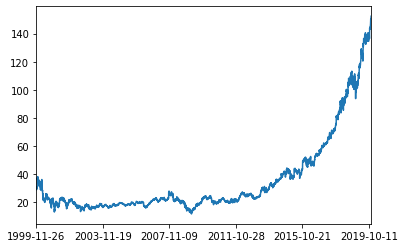

In [15]:
df.sort_index(inplace=True)
df[0].astype('float').plot()

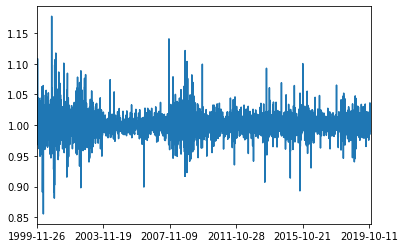

In [16]:
div.sort_index(inplace=True)
div.plot()

In [17]:
div.describe(percentiles=[.01,.1,.25,.5,.75,.9,.95,.99])

count    5033.000000
mean        1.000495
std         0.018362
min         0.855380
1%          0.951281
10%         0.981728
25%         0.991927
50%         1.000361
75%         1.008711
90%         1.019803
95%         1.027438
99%         1.052547
max         1.177514
Name: 0, dtype: float64

In [18]:
div

1999-11-26         NaN
1999-11-29    0.983628
1999-11-30    0.995894
1999-12-01    1.014596
1999-12-02    1.021964
                ...   
2019-11-21    0.993946
2019-11-22    1.004485
2019-11-25    0.999534
2019-11-26    1.009067
2019-11-27    1.006409
Name: 0, Length: 5034, dtype: float64

In [19]:
dateAnnotated = {}

dateAnnotated[2] = annotateBuyOrSellTwoClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[2], orient='index')
df[0].value_counts()

S    2571
B    2462
Name: 0, dtype: int64

In [20]:
dateAnnotated[8] = annotateBuyOrSellEightClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[8], orient='index')
df[0].value_counts()

S0    811
B0    808
S2    643
S1    639
B2    616
B1    590
S3    478
B3    448
Name: 0, dtype: int64

In [21]:
import pandas as pd

normalizedIndicators = {}
normalizedIndicators[2] = getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotated[2])
normalizedIndicators[8] = getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotated[8])

data = {}
data[2] = pd.DataFrame.from_dict(normalizedIndicators[2], orient='index')
data[8] = pd.DataFrame.from_dict(normalizedIndicators[8], orient='index')

Normalizing and annotating indicators
Normalizing and annotating indicators


In [22]:
data[2] = pd.DataFrame.merge(pd.DataFrame(data[2].indicators.values.tolist(), index=data[2].index), data[2], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])
data[8] = pd.DataFrame.merge(pd.DataFrame(data[8].indicators.values.tolist(), index=data[8].index), data[8], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [23]:
data[2].head(), data[8].head()

(                 SMA annotation
 2019-11-27  0.983618          S
 2019-11-26  0.985900          S
 2019-11-25  0.991121          B
 2019-11-22  0.987225          S
 2019-11-21  0.987250          B,                  SMA annotation
 2019-11-27  0.983618         S1
 2019-11-26  0.985900         S1
 2019-11-25  0.991121         B0
 2019-11-22  0.987225         S0
 2019-11-21  0.987250         B1)

In [24]:
data[2].annotation = data[2].annotation.apply(lambda x: 0 if x == 'S' else 1)

eight_dict = {"B3":0, "B2": 1, "B1": 2, "B0": 3, "S0": 4, "S1": 5, "S2": 6, "S3": 7}
data[8].annotation = data[8].annotation.apply(lambda x: eight_dict[x])

In [25]:
data[2] = data[2].sort_index()
data[8] = data[8].sort_index()

In [26]:
data[2] = data[2].dropna()
data[8] = data[8].dropna()

In [27]:
len(data[2]), len(data[8])

(5025, 5025)

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

data_analysis = pd.DataFrame.merge(data[2], div, left_index=True, right_index=True, how='inner')
X = data_analysis.iloc[:,:8]
y = data_analysis.iloc[:,-1:]

In [29]:
bestfeatures = SelectKBest(score_func=f_classif, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(8,'Score'))

ValueError: k should be >=0, <= n_features = 3; got 8. Use k='all' to return all features.

In [ ]:
corrmat = data_analysis.iloc[:,:8].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
plt.axis('scaled')
g=sns.heatmap(data_analysis[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models = ["mlp","lstm"]
classes = {2: ["S","B"],
           8: ["B3","B2","B1","B0","S0","S1","S2","S3"]}
n_classes = [2, 8]
n_steps = [2,5,10]
n_indicators = {
    3: ['SMA','MOM','RSI'], 
    6: ['SMA','MOM','RSI', 'MACD','ADX','WILLR']
}

batch_size = 32
train_split = .8

# X [d: (all, train, test)] [m: type(mlp/lstm)] [c: classes(2, 8)] [s: n_steps(2,5,10)] [i: indicators(3, 6, 8)] 

In [ ]:
X = {}
y = {}
for a in ["all", "train", "test"]:
    X[a] = {}
    y[a] = {}
    for m in models:
        X[a][m] = {}
        y[a][m] = {}
        for c in n_classes:
            X[a][m][c] = {}
            y[a][m][c] = {}
            for s in n_steps:
                X[a][m][c][s] = {}
                y[a][m][c][s] = {}
                for i in n_indicators.keys():
                    X[a][m][c][s][i] = []
                    y[a][m][c][s][i] = []
                    if a == "all":
                        for d in range(len(data[c])):
                            end_ix = d + s
                            if end_ix > len(data[c]):
                                break
                            seq_x, seq_y = data[c].loc[data[c].index.isin(data[c].index[d:end_ix]), n_indicators[i]].values, data[c].iloc[end_ix-1, -1]
                            if m == "lstm":
                                X[a][m][c][s][i].append(seq_x)
                            else:
                                X[a][m][c][s][i].append(seq_x.flatten())
                            if c == 2:
                                y[a][m][c][s][i].append(seq_y)
                            else:
                                y[a][m][c][s][i].append(np.eye(c)[seq_y])
                        X[a][m][c][s][i] = np.array(X[a][m][c][s][i])
                        y[a][m][c][s][i] = np.array(y[a][m][c][s][i])

In [ ]:
a = 'all'
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

In [ ]:
data[2].head()

In [ ]:
X["all"]["lstm"][2][5][8][0]

In [ ]:
X["all"]["mlp"][2][2][8][0]

In [ ]:
from sklearn.model_selection import train_test_split

for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                if m == "mlp":
                    X['train'][m][c][s][i], X['test'][m][c][s][i], y['train'][m][c][s][i], y['test'][m][c][s][i] = train_test_split(X['all'][m][c][s][i], y['all'][m][c][s][i], train_size=train_split, random_state=0)
                else:
                    X['train'][m][c][s][i] = X['all'][m][c][s][i][:int(len(X['all'][m][c][s][i])*train_split)]
                    X['test'][m][c][s][i] = X['all'][m][c][s][i][int(len(X['all'][m][c][s][i])*train_split):]
                    y['train'][m][c][s][i] = y['all'][m][c][s][i][:int(len(y['all'][m][c][s][i])*train_split)]
                    y['test'][m][c][s][i] = y['all'][m][c][s][i][int(len(y['all'][m][c][s][i])*train_split):]

In [ ]:
for a in ['train','test']:
    for m in models:
        for c in n_classes:
            for s in n_steps:
                for i in n_indicators:
                    print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

In [ ]:
Models = {}
for m in models:
    Models[m] = {}
    for c in n_classes:
        Models[m][c] = {}
        for s in n_steps:
            Models[m][c][s] = {}
            for i in n_indicators:
                Models[m][c][s][i] = {}
                if c == 2:
                    out = 1
                else:
                    out = c
                if m == "mlp":
                    Models[m][c][s][i] = getModelMLP(s, i, out)
                else:
                    Models[m][c][s][i] = getModelBidirectionalLSTM(s, i, out)

In [ ]:
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(Models[m][c][s][i])

In [ ]:
history = {}
preds = {}
conf = {}
for m in models:
    history[m] = {}
    preds[m] = {}
    conf[m] = {}
    for c in n_classes:
        history[m][c] = {}
        preds[m][c] = {}
        conf[m][c] = {}
        for s in n_steps:
            history[m][c][s] = {}
            preds[m][c][s] = {}
            conf[m][c][s] = {}
            for i in n_indicators:
                history[m][c][s][i] = {}
                preds[m][c][s][i] = {}
                conf[m][c][s][i] = {}

In [ ]:
# Calculando lucro/prejuízo total, supondo que inicialmente temos US$1000 em carteira
import copy

def calculateProfit(preds, stockPrices):
    classificationArray = list(np.argmax(preds["lstm"][8], axis=1))

    prices = copy.deepcopy(stockPrices)

    for date in sorted(stockPrices.keys()):
        if len(prices) == len(classificationArray):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0

    for date in sorted(prices.keys()):
        stockPrice = float(prices[date])
        classification = classificationArray[index]
        # Caso de compra
        if currentMoney != 0 and (classification == 0 or classification == 1 or classification == 2 or classification == 3):
            currentStocks = currentMoney/stockPrice
            currentMoney = 0.0
        elif currentStocks != 0 and (classification == 4 or classification == 5 or classification == 6 or classification == 7):
            currentMoney = currentStocks*stockPrice
            currentStocks = 0.0
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice

    growthPercentage = 100.0*((finalMoney-initialMoney)/initialMoney)
    timeLenInYears = len(prices)/252.0

    print("[DEBUG] Current money:\t   US$ " + str(round(currentMoney, 2)))
    print("[DEBUG] Current stocks:\t   " + str(round(currentStocks, 2)) + "\t| Last stock-price: US$ " + str(round(lastPrice, 2)))
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + firstPrice)
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + lastPrice)
    print("Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Growth percentage: " + str(round(growthPercentage, 2)) + "%")
    print("Growth per year:   US$ " + str(round((finalMoney-initialMoney)/timeLenInYears, 2)))

In [ ]:
def fit(m, c, s, i):
    history[m][c][s][i] = Models[m][c][s][i].fit(
        X['train'][m][c][s][i], 
        y['train'][m][c][s][i], 
        epochs=300, 
        verbose=1,
        batch_size=batch_size)
    plt.plot(history[m][c][s][i].history['loss'], label='train')
#     plt.plot(history[m][c][s][i].history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def predict(m, c, s, i):
    preds[m][c][s][i] = Models[m][c][s][i].predict(
        X['test'][m][c][s][i], 
        batch_size=batch_size)
    print(f"Model {m}\nNumber of classes {c}\nNumber of steps {s}\nNumber of indicators {i}")
    print(classification_report(y['test'][m][c][s][i], 
                                np.rint(preds[m][c][s][i]).astype(np.int64), 
                                target_names=classes[c], 
                                digits=5))
    if c == 2:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i], 
                                                 np.rint(preds[m][c][s][i]).astype(np.int64), 
                                                 classes=np.array(classes[c]))
    else:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i].argmax(axis=1), 
                                                 np.rint(preds[m][c][s][i]).argmax(axis=1), 
                                                 classes=np.array(classes[c]))
        
def get_next_value(m, c, s, i):
    i = n_indicators[(n_indicators.index(i) + 1)%len(n_indicators)]
    if (n_indicators.index(i) == 0):
        s = n_steps[(n_steps.index(s) + 1)%len(n_steps)]
        if (n_steps.index(s) == 0):
            c = n_classes[(n_classes.index(c) + 1)%len(n_classes)]
            if (n_classes.index(c) == 0):
                m = models[(models.index(m) + 1)%len(models)]    
    return m, c, s, i

In [ ]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

for x in range(36):
    Models[m][c][s][i].summary()
    m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)